# Real-Time Beat Detection with BPM Plotting

This notebook captures audio from your microphone and displays the current tempo estimate in real-time.

In [1]:
import numpy as np
import librosa
import sounddevice as sd
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import clear_output

In [2]:
# Configuration
SAMPLE_RATE = 22050  # Hz
BUFFER_DURATION = 30  # seconds of audio to analyze (increased for more context)
CHUNK_DURATION = 0.5  # seconds per update
HISTORY_LENGTH = 30  # number of BPM estimates to keep

# Librosa beat tracking parameters for stability
START_BPM = 120  # Initial guess for tempo
TIGHTNESS = 200  # Higher = more stable tempo (default is 100)

buffer_size = int(SAMPLE_RATE * BUFFER_DURATION)
chunk_size = int(SAMPLE_RATE * CHUNK_DURATION)

In [3]:
# Initialize buffers
audio_buffer = np.zeros(buffer_size)
bpm_history = deque(maxlen=HISTORY_LENGTH)
time_history = deque(maxlen=HISTORY_LENGTH)
current_time = 0
last_bpm = START_BPM  # Track the last BPM estimate for stability

In [4]:
def process_audio_chunk(audio_chunk):
    """Process audio chunk and return BPM estimate"""
    global audio_buffer, current_time, bpm_history, time_history, last_bpm
    
    # Roll buffer and add new chunk
    audio_buffer = np.roll(audio_buffer, -len(audio_chunk))
    audio_buffer[-len(audio_chunk):] = audio_chunk.flatten()
    
    # Detect tempo with stability parameters
    try:
        # Use the last BPM as a starting point and tightness for stability
        tempo, _ = librosa.beat.beat_track(
            y=audio_buffer, 
            sr=SAMPLE_RATE,
            start_bpm=last_bpm,  # Use previous estimate as starting point
            tightness=TIGHTNESS  # Higher value = more stable tempo
        )
        bpm = tempo
        
        # Keep BPM in the range [100, 200] by multiplying or dividing
        while bpm < 100:
            bpm *= 2
        while bpm > 200:
            bpm /= 2
        
        last_bpm = bpm  # Update for next iteration
    except Exception:
        bpm = last_bpm  # Fall back to last known BPM on error
    
    # Update BPM history
    bpm_history.append(bpm)
    time_history.append(current_time)
    current_time += CHUNK_DURATION
    
    return bpm

In [5]:
def update_plot():
    """Update the BPM plot"""
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 4))
    
    if len(bpm_history) > 0:
        plt.plot(list(time_history), list(bpm_history), 'b-', linewidth=2)
        plt.scatter(list(time_history)[-1:], list(bpm_history)[-1:], 
                   color='red', s=100, zorder=5)
        
        current_bpm = list(bpm_history)[-1]
        current_bpm = current_bpm.item() if isinstance(current_bpm, np.generic) else float(current_bpm)
        plt.title(f'Real-Time BPM Detection - Current: {current_bpm:.1f} BPM', 
                 fontsize=14, fontweight='bold')
    else:
        plt.title('Real-Time BPM Detection - Waiting for audio...', 
                 fontsize=14, fontweight='bold')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('BPM')
    plt.ylim(100, 200)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

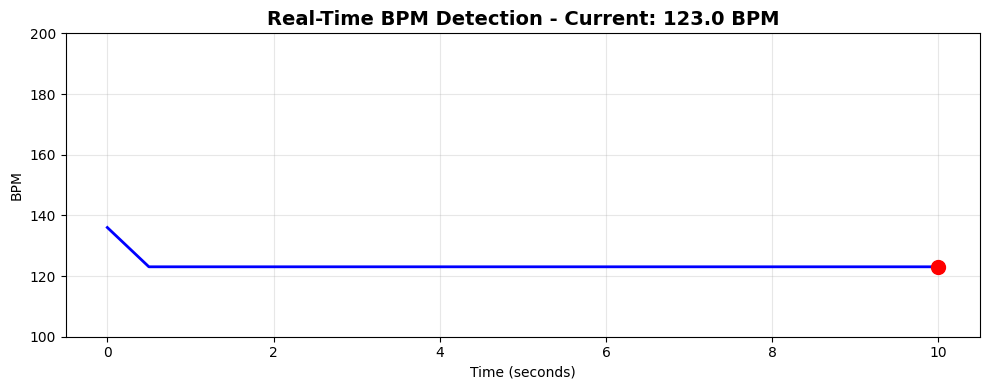


Stopped.


In [6]:
# Real-time detection loop
print("Starting real-time beat detection...")
print("Play some music or make rhythmic sounds!")
print(f"Using start_bpm={START_BPM}, tightness={TIGHTNESS}")
print("Press Ctrl+C or interrupt the kernel to stop.\n")

try:
    with sd.InputStream(samplerate=SAMPLE_RATE, channels=1, 
                        blocksize=chunk_size) as stream:
        iteration = 0
        while True:
            # Read audio chunk
            audio_chunk, _ = stream.read(chunk_size)
            
            # Process and get BPM
            bpm = process_audio_chunk(audio_chunk)
            
            # Update plot every iteration
            update_plot()
            
            iteration += 1
            
except KeyboardInterrupt:
    print("\nStopped.")